In [1]:
from dlroms import*
import numpy as np

## **Fisher-KPP equation**: damage propagation in a U-bolt

In [2]:
# FOM discretization
import gdown
gdown.download(id = "1_4uC_yjWmvaDfAuRt0I1PI3IENE4XYXX", output = "ubolt_mesh.xml")
mesh = fe.loadmesh("ubolt_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()

In [3]:
# Dataset (parameters and FKPP simulations)
gdown.download(id = "1ehojde4rL-8-zoyiKikes3e76CpPvJzC", output = "ubolt.npz")
clc()
dataset = np.load("ubolt.npz")
mu, u = dataset['mu'], dataset['u']

In [4]:
# Fancy colormap for plotting
from matplotlib.colors import ListedColormap
import matplotlib as mpl
jet = mpl.colormaps['jet']
jet_colors = jet(np.linspace(0, 1, 256))
def modify_jet_to_gray(jet_colors):
    new_colors = jet_colors.copy()
    gray_vals = np.linspace(0.3, 0.7, 85)
    for i in range(85):
        new_colors[i, 0:3] = gray_vals[i]
    return ListedColormap(new_colors)
gray_jet = modify_jet_to_gray(jet_colors)

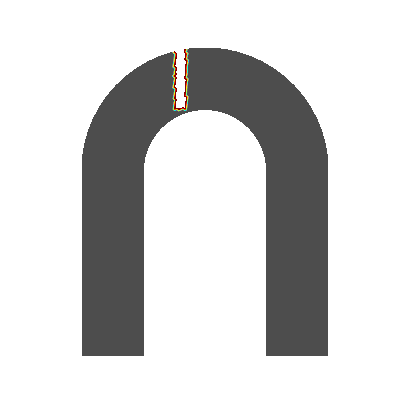

In [5]:
# First simulation in the dataset
fe.animate(u[0], Vh, cmap = gray_jet)

In [6]:
from dlroms.minns import Integral
u = dv.tensor(u).cpu()
ns, nt, nh = u.shape

space_integral = Integral(Vh)
clc()

def J(u):
  return space_integral(u).reshape(-1, nt).mean(axis = -1)

J(u).shape # Values of the functional J (see task (iii) - (iv)) across the dataset

J(u[:3]) # Values of the functional J on the first, second and third simulation

tensor([1.5723, 1.2846, 0.3781])

In [7]:
mu.shape,u.shape

((100, 3), torch.Size([100, 41, 6636]))

In [8]:
mu,u=dv.tensor(dataset['mu']),dv.tensor(dataset['u'])
display(mu.shape,u.shape)
ndata,ntimes,nh=u.shape
p=mu.shape[-1]
print("Trajectories:\t%d."% ndata)
print("Timesteps:\t%d."%ntimes)
print("FOM dimension:\t%d."%nh)
print("Parameters:\t%d."%p)

mut=dv.zeros(ndata,ntimes,p+1) #p+1 perche abbiamo la parametrizzazione + il tempo
times=dv.tensor(np.linspace(0,1,ntimes))
for i in range(ndata):
  mut[i,:,:3]=mu[i]
  mut[i,:,-1]=times

print(mut.shape) #tensore che contiene ndata x ntimes x (p+1)

torch.Size([100, 3])

torch.Size([100, 41, 6636])

Trajectories:	100.
Timesteps:	41.
FOM dimension:	6636.
Parameters:	3.
torch.Size([100, 41, 4])


In [9]:
u=u.reshape(-1,nh)
mut=mut.reshape(-1,p+1)
print(u.shape,mut.shape)

torch.Size([4100, 6636]) torch.Size([4100, 4])


In [10]:
l2=L2(Vh)
l2.cuda()
clc()
ntrain=75*ntimes #75 simulazioni per il train-set
ntest=25*ntimes  #25 simulazioni per il test-set
def error(utrue,upred):
  return ((l2(utrue-upred).reshape(-1,ntimes).sum(axis=-1))/l2(utrue).reshape(-1,ntimes).sum(axis=-1)).mean()

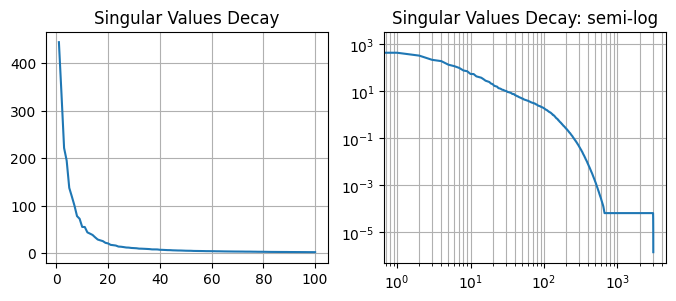

In [11]:
from scipy.linalg import svd
import matplotlib.pyplot as plt
%matplotlib inline

X,s,_=svd(u[:ntrain].T.cpu().numpy(),full_matrices=False)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(1+np.arange(100),s[1:101])
plt.grid()
plt.title("Singular Values Decay")
plt.subplot(1,2,2)
plt.title("Singular Values Decay: semi-log")
plt.loglog(s)
plt.grid(True,which='both')
plt.show()

In [12]:
from torch.optim import Adam
rho_e=lambda x:relu(x) -10*relu(-x)
rho_d= lambda x:relu(x) -0.1*relu(-x)

Latent=9
encoder=Dense(nh,50,rho_e)+Dense(50,Latent,rho_e)
decoder=Dense(Latent,50,rho_d)+Dense(50,100,rho_d)+Dense(100,nh,activation=None)
autoencoder=DFNN(encoder+decoder)

autoencoder.He()
autoencoder.cuda()

autoencoder.train(u,u,ntrain=ntrain,  epochs=30, loss=mse(l2),
                  error=error,notation='%')

autoencoder.train(u,u,ntrain=ntrain, epochs=2000, loss=mse(l2),
                  optim=Adam, lr=1e-5, batchsize=64,
                  error=error, notation='%')




		Train	Test
Epoch 2000:	4.79%	5.86%.

>> ETA: 0.34s.

Training complete. Elapsed time: 11 minutes 15.68 seconds.


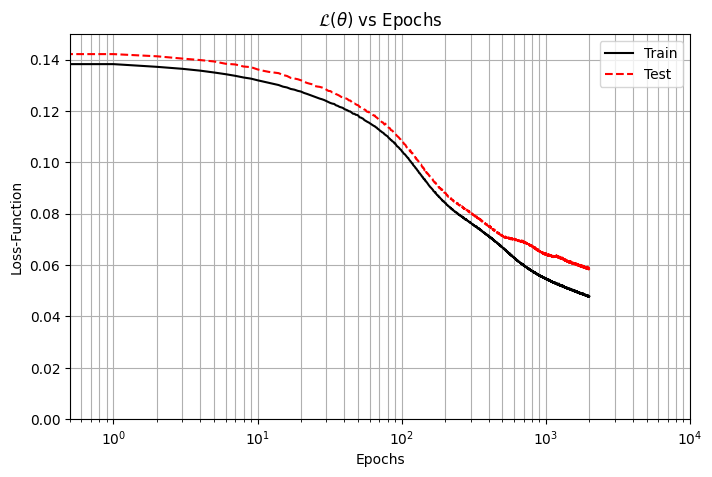

In [13]:

plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}(\theta)$ vs Epochs')
plt.semilogx(autoencoder.errors['Train'], '-k', label = 'Train')
#plt.semilogx(autoencoder.errors['Validation'], 'b', label = 'Validation')
plt.semilogx(autoencoder.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 1e+4, 0, 0.15])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [14]:
autoencoder.freeze()

In [15]:
print("Autoencoder MRE: %s"%num2p(error(u[ntrain:],autoencoder(u[ntrain:]))))

Autoencoder MRE: 5.86%


In [16]:
nu=encoder(u)
from dlroms.dnns import Fourier
fmodes=10
phi=DFNN(Fourier(fmodes, which=[-1]) + Dense(p+1+2*fmodes, 500, gelu) + Dense(500, Latent, activation = None))

phi.He()
phi.cuda()
phi.train(mut,nu,ntrain=ntrain, epochs=150,loss=mse(euclidean))
phi.freeze()

		Train		Test
Epoch 150:	6.10e+01	2.14e+03.

>> ETA: 0.76s.

Training complete. Elapsed time: 1 minutes 54.25 seconds.


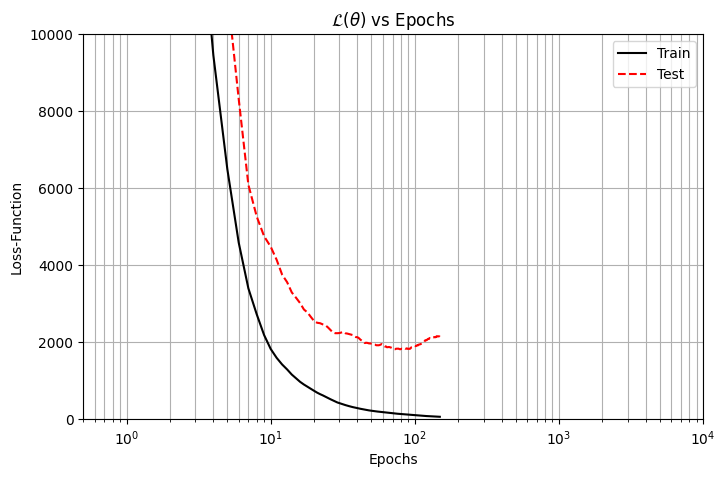

In [17]:
plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}(\theta)$ vs Epochs')
plt.semilogx(phi.errors['Train'], '-k', label = 'Train')
plt.semilogx(phi.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 1e+4, 0, 1e+4])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [18]:
dlrom = lambda mt: decoder(phi(mt))
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'8.65%'

In [19]:
def visualize(uexample):
    fe.animate(uexample[::2], Vh, figsize = (8, 2),colorbar=True)

#visualize(u[0])

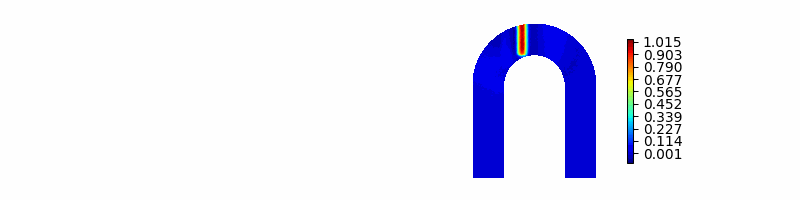

DL-ROM simulation time: 0.002s.


In [20]:
from time import perf_counter
mu0 = dv.tensor([5.8e-01, 7.2e-01, 6.1e-01])

mu0t = dv.zeros(ntimes, p+1)
mu0t[:, 3] = times
mu0t[:, :3] = mu0

t0 = perf_counter()
uROM = dlrom(mu0t)
t1 = perf_counter()
visualize(uROM)
print("DL-ROM simulation time: %.3fs." % (t1-t0))

In [21]:
print(uROM.shape)
uROM_III=uROM.cpu()
print(uROM_III.shape)
J(uROM_III)  #la funzione "J" prende dentro un torch.tensor() non np.array() !

torch.Size([41, 6636])
torch.Size([41, 6636])


tensor([1.6479])

In [22]:
print(mu[:,0].shape)
print(mut.reshape(100,41,-1).shape)
mut=mut.reshape(100,41,-1)

torch.Size([100])
torch.Size([100, 41, 4])


In [23]:
uROM_out=[]                       #list
mut_eval=dv.zeros(ndata,ntimes,4) #tensor
for i in range(ndata):            #ndata=100
    mut_eval=mut[i,:,:]           #variation of parameters per single simulation
    uROM=dlrom(mut_eval)          #evalutation of mut-tensor by means of the surrogate model! (performing 100 simulations in 0.4s)
    uROM_out.append(uROM.cpu().numpy())

uROM_val=np.stack(uROM_out)
print(uROM_val.shape)

(100, 41, 6636)


In [24]:
import torch
uROM_val=torch.from_numpy(uROM_val)
J(uROM_val)

tensor([1.5781, 1.2912, 0.3779, 1.5232, 1.5724, 1.6432, 0.8831, 1.1538, 4.5307,
        0.6155, 0.4310, 0.3336, 1.1143, 0.6607, 1.7619, 0.5042, 0.7640, 0.7898,
        1.0680, 1.1072, 2.7091, 0.4599, 0.6931, 2.9396, 2.2891, 1.5131, 0.8177,
        1.7921, 1.2187, 0.6684, 0.8218, 2.3719, 0.9362, 0.6737, 1.0506, 0.5738,
        1.4274, 1.1760, 1.9479, 1.9469, 0.3994, 0.3662, 2.5513, 0.7756, 0.5214,
        1.5543, 1.5843, 2.0670, 1.4238, 0.5000, 0.5031, 0.4040, 0.3969, 1.4381,
        0.6152, 1.9993, 0.9410, 0.4188, 0.7514, 0.6113, 0.4330, 0.6047, 0.6125,
        0.6811, 0.9566, 0.3291, 0.3770, 2.3041, 0.3599, 1.5302, 3.5536, 0.5818,
        0.9568, 1.1407, 1.3124, 0.4265, 1.5905, 1.8968, 0.8934, 0.8707, 1.4433,
        0.6119, 1.0134, 1.0981, 0.5031, 1.0162, 0.4001, 3.4676, 1.0682, 0.5332,
        0.3962, 0.5218, 2.6497, 1.4232, 1.4347, 0.4427, 1.8721, 4.2162, 1.2886,
        1.0479])

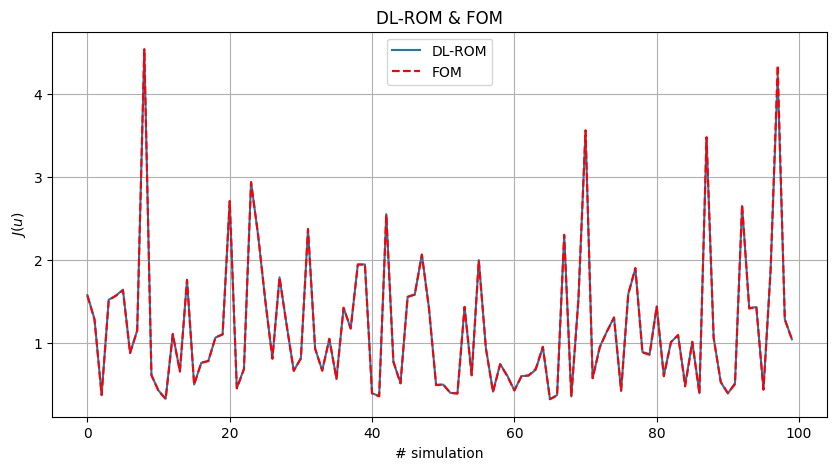

In [25]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.title("DL-ROM & FOM")
plt.plot(J(uROM_val),label="DL-ROM")
plt.plot(J(u.cpu()),color='r',ls='dashed',label="FOM")
plt.legend()
plt.ylabel(r'$J(u)$')
plt.xlabel('# simulation')
plt.grid()
plt.show()

Difference between the DL-ROM and the FOM in order to check the goodness of the approximation acchieved

In [26]:
diff=J(uROM_val)-J(u.cpu()) #difference

Text(0, 0.5, '$J(\\tilde{u})-J(u)$')

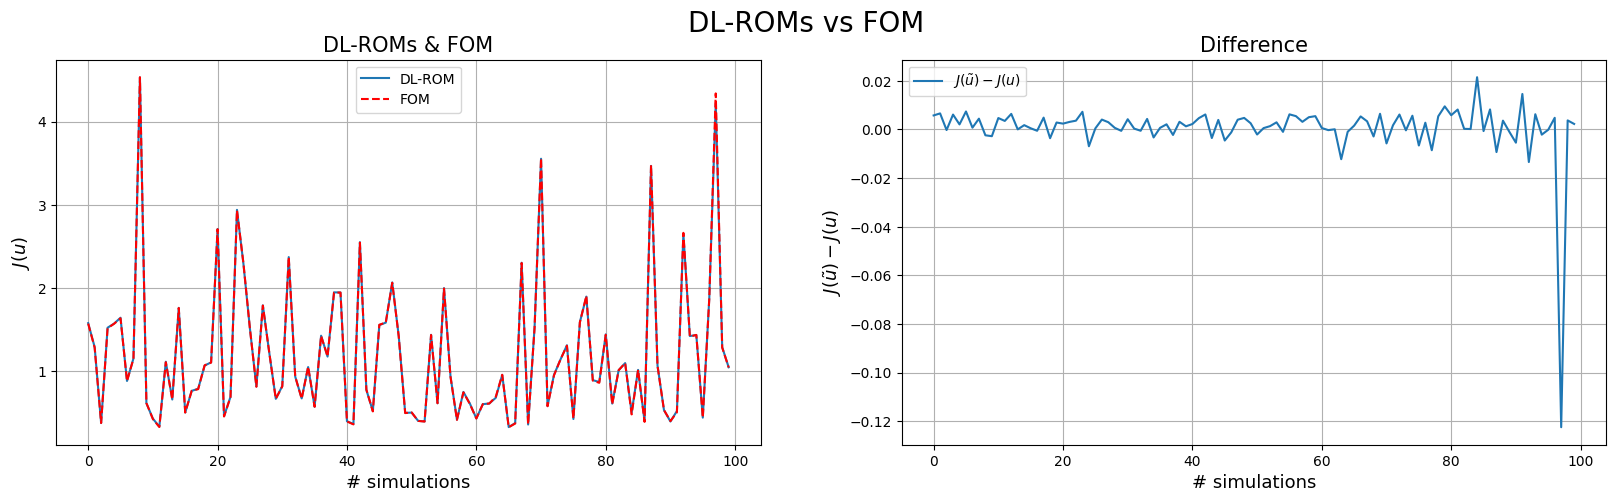

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('DL-ROMs vs FOM',size="20")
ax1.set_title("DL-ROMs & FOM",size="15")
ax1.plot(J(uROM_val),label="DL-ROM")
ax1.plot(J(u.cpu()),color='r',ls='dashed',label="FOM")
ax1.grid()
ax1.set_xlabel("# simulations",size="13")
ax1.set_ylabel("$J(u)$",size="13")
ax1.legend()
ax2.set_title("Difference",size="15")
ax2.plot(diff,label=r"$J(\tilde{u})-J(u)$")
ax2.grid()
ax2.legend()
ax2.set_xlabel("# simulations",size="13")
ax2.set_ylabel(r"$J(\tilde{u})-J(u)$",size="13")

## SINDy
Utilizzare SINDy in questo caso può essere interessante per fittare la soluzione e trovare la "governing equation" del problema U-bolt

In [28]:
import numpy as np
import pysindy as ps

t = np.linspace(0, 0.0205, 41)
print(t.shape)
coords = mesh.coordinates()[:,:2]
print(np.shape(coords))

(41,)
(6636, 2)


In [29]:
u=u.reshape(ndata,len(t),-1)
print(u.shape)
u=u.cpu().numpy()

torch.Size([100, 41, 6636])


In [31]:
dt=5e-4
u_sol = u[0, :, :] #0 is the number of simulation 100 is the last one, "ndata"
u_dot = ps.FiniteDifference(axis=1,order=2)._differentiate(u_sol, dt) # "SmoothedFiniteDifference" for noisy datas (1. Filtered -> 2. Central Euler Scheme)

# Choose 75 % of data for training because data is big...
# can only randomly subsample if you are passing u_dot to model.fit!!!
train = np.random.choice(ntimes, int(ntimes * 0.99), replace=False)
test = [i for i in np.arange(len(times)) if i not in train]
u_train = u[0, train,: ]
u_test = u[0, test, :]
u_dot_train = u_dot[ train,: ]
u_dot_test = u_dot[ test, :]
t_train = t[train]
t_test = t[test]

In [33]:
print(np.shape(u_train))
#print(np.shape(spatial_grid))
print(np.shape(coords))

(40, 6636)
(6636, 2)


# First-Test (non-sense)
Questo test considerata solo l'ultimo time step del problema: cioè fitto solo gli ultimi valori associati ai dof all'istante finale. Ha poco senso è solo per vedere come funziona SINDy

In [34]:
stlsq_optimizer = ps.STLSQ(threshold=1e-1, alpha=1e-1, verbose=True)
model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(u[0,-1,:], t=dt) #il vettore delle soluzioni deve essere in x,y mentre qui è solo dofs(x,y non separati)
model.print()

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.4639e+07 ... 7.9749e+01 ...          3 ... 1.4639e+07
(x0)' = 0.698 1 + -19.679 x0 + 20.442 x0^2


/home/orion/anaconda3/envs/dl-rom/lib/python3.10/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


# Model discovery on the FOM data
Devo ora in qualche modo introdurre derivate del secondo ordine nel modello in quanto cio che viene recuperato da SINDy è solo un problema di trasporto, quando so per certo che il problema è di "diffusione + reazione" quindi ci sono derivate seconde: Laplaciano + Reazione non lineare. Cio  che trova SINDy è un problema di "mild-transport" non lineare a sua volta con ulteriori 3 termini di reazione non lineari. La determinazione della PDE finale dipende estremamente dalla selezione della _threshold_ in $\texttt{STLSQ}$ e dal valore di penalty (sparsity constrain) $\lambda$

$$u_t=-0.041 u + 0.136 u^2 -0.099 u^3 + 0.008 u_x -0.001 u^2u_x$$


In [35]:
x_coords=coords[:,0]
y_coords=coords[:,1]
u_flat=np.reshape(u_train,(-1,1))          #(ntimes*nh,1), for SINDy is better to use a flattened vector of my solutions (inclusion of time and dofs)
u_dot_flat=np.reshape(u_dot_train,(-1,1))   
print(u_flat.shape)
x=np.linspace(0,1,len(u_flat))             # x for SINDy

(265440, 1)


### Usando STLSQ

In [36]:
pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=3,include_bias=False),
    derivative_order=2,  # up to second-order spatial derivaties
    spatial_grid=x,
    include_bias=True,  # cross terms u * u_x, etc.
    is_uniform=False,    # for unstructured grid
    periodic=False
)
stlsq_optimizer = ps.STLSQ(threshold=0.1, alpha=1e-16,max_iter=200, verbose=True,normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=stlsq_optimizer)
model.fit(u_flat, x_dot=u_dot_flat,t=dt) # Fitting method from sklearn
model.print()


/home/orion/anaconda3/envs/dl-rom/lib/python3.10/site-packages/pysindy/feature_library/pde_library.py:110: UserWarning: is_uniform and periodic have been deprecated.in favor of differetiation_method and diff_kwargs.
  warnings.warn(
/home/orion/anaconda3/envs/dl-rom/lib/python3.10/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.7442e+01 ... 8.4895e-08 ...         11 ... 1.7442e+01
         1 ... 1.7475e+01 ... 8.4896e-08 ...         11 ... 1.7475e+01
(x0)' = -0.041 x0 + 0.136 x0^2 + -0.099 x0^3 + 0.008 x0_1 + -0.001 x0^2x0_1


### Usando SR3

In [37]:
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    reg_weight_lam=0.005,
        regularizer="L0",
        relax_coeff_nu=1.0e+2,
        tol=1e-5,
        trimming_fraction=0.0,
        trimming_step_size=1.0,
        max_iter=1000,
        copy_X=True,
        initial_guess=None,
        normalize_columns=True,
        verbose=True,
        unbias=False,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flat, x_dot=u_dot_flat)
model.print()

SR3 model, L0 norm: 


/home/orion/anaconda3/envs/dl-rom/lib/python3.10/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.0528e+01 ... 3.0420e-02 ... 6.0000e-02 ... 1.3630e+01
       100 ... 1.7323e+01 ... 1.6210e-02 ... 6.0000e-02 ... 1.9004e+01
(x0)' = 0.008 x0_1


In [38]:
print("2nd order derivative library: ")
print(pde_lib.get_feature_names())

2nd order derivative library: 
['1', 'x0', 'x0^2', 'x0^3', 'x0_1', 'x0_11', 'x0x0_1', 'x0^2x0_1', 'x0^3x0_1', 'x0x0_11', 'x0^2x0_11', 'x0^3x0_11']
